<a href="https://colab.research.google.com/github/qubit19/fast-parallel-disease-model/blob/main/diseasespread.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycuda numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 8.2 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1-cp311-cp311-linux_x86_64.whl size=660426 sha256=50d5b82ea2bfb4fa02a5ad8ae01755c96a7a20ba0720b4f9eec65239a23ee6bf
  Stored in directory: /root/.cache/pip/wheels/77/7e/6c/d2d1451ea6424cdc3d67b36c16fa7111eafdf2034bc3405666
Successfully built pycuda


In [ ]:
!apt-get update
!apt-get install -y cuda
!ldconfig

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,863 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubu

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
from pycuda.compiler import SourceModule

# Define kernel to simulate FPP process
kernel_code = """
__global__ void disease_spread_kernel(float *grid, float *infection_times, int *infected, int grid_size) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    int idy = threadIdx.y + blockIdx.y * blockDim.y;

    if (idx < grid_size && idy < grid_size) {
        int idx_1d = idx * grid_size + idy;

        // Check if the node is infected
        if (infected[idx_1d] == 1) {
            // Spread the infection to neighboring nodes
            for (int dx = -1; dx <= 1; dx++) {
                for (int dy = -1; dy <= 1; dy++) {
                    if (dx == 0 && dy == 0) continue;
                    int nx = idx + dx;
                    int ny = idy + dy;
                    if (nx >= 0 && ny >= 0 && nx < grid_size && ny < grid_size) {
                        int neighbor_idx = nx * grid_size + ny;
                        if (infection_times[neighbor_idx] > infection_times[idx_1d] + grid[neighbor_idx]) {
                            infection_times[neighbor_idx] = infection_times[idx_1d] + grid[neighbor_idx];
                            infected[neighbor_idx] = 1; // Mark as infected
                        }
                    }
                }
            }
        }
    }
}
"""

# Compile the CUDA code
mod = SourceModule(kernel_code)
disease_spread_kernel = mod.get_function("disease_spread_kernel")



In [ ]:
# Grid parameters
grid_size = 100  # You can adjust this for larger/smaller grids
population = grid_size * grid_size

# Initialize the grid with random weights representing transmission probabilities
grid = np.random.rand(population).astype(np.float32)

# Initialize infection times, set the first infected person
infection_times = np.full(population, np.inf, dtype=np.float32)
infection_times[0] = 0  # First person gets infected at time = 0

# Infected array to track which nodes are infected
infected = np.zeros(population, dtype=np.int32)
infected[0] = 1  # Initially infect one person (index 0)

# Copy data to GPU
grid_gpu = cuda.mem_alloc(grid.nbytes)
infection_times_gpu = cuda.mem_alloc(infection_times.nbytes)
infected_gpu = cuda.mem_alloc(infected.nbytes)

# Transfer data to GPU
cuda.memcpy_htod(grid_gpu, grid)
cuda.memcpy_htod(infection_times_gpu, infection_times)
cuda.memcpy_htod(infected_gpu, infected)


In [ ]:
# Define a function to run the disease spread simulation
def run_simulation(grid_gpu, infection_times_gpu, infected_gpu, grid_size, iterations=1000):
    block_size = (16, 16, 1)  # Choose block size for the GPU kernel
    grid_size_2d = (grid_size, grid_size)
    for _ in range(iterations):
        disease_spread_kernel(grid_gpu, infection_times_gpu, infected_gpu, np.int32(grid_size), block=block_size, grid=grid_size_2d)

# Run the simulation
run_simulation(grid_gpu, infection_times_gpu, infected_gpu, grid_size)


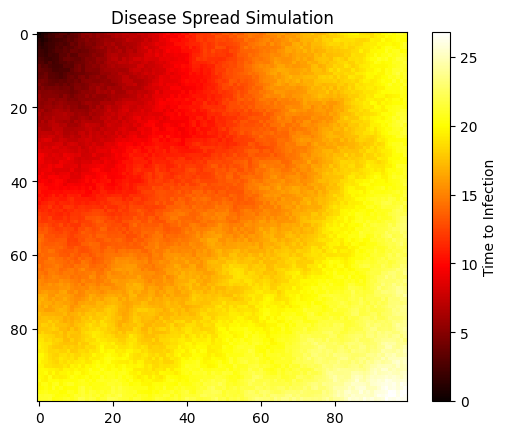

In [ ]:
import matplotlib.pyplot as plt

# copy from GPU to CPU
cuda.memcpy_dtoh(infection_times, infection_times_gpu)
cuda.memcpy_dtoh(infected, infected_gpu)

# Reshape for visualization
infection_times_reshaped = infection_times.reshape((grid_size, grid_size))

# Plot the spread of disease (infection times)
plt.imshow(infection_times_reshaped, cmap='hot', interpolation='nearest')
plt.colorbar(label="Time to Infection")
plt.title("Disease Spread Simulation")
plt.show()


In [ ]:
!nvidia-smi

Sat Apr 26 11:08:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----